# Prepare some things
## Load some modules

In [1]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from scipy.cluster import hierarchy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
# from models import get_autoencoder_model, get_dec_model, get_vae_model, get_clustering_vae_model, get_vade_models, compute_p, compute_delta
from clustering_metrics import evaluate_model, evaluate_clustering
from draw_embeddings import draw_embeddings, draw_matched_labels

## Load the dataset

In [3]:
codebook = pd.read_csv("ExposomeChallengeData/datasets/codebook.csv", index_col=0)
phenotype = pd.read_csv("ExposomeChallengeData/datasets/phenotype.csv", index_col=0)
exposome = pd.read_csv("ExposomeChallengeData/datasets/exposome.csv", index_col=0)
covariates = pd.read_csv("ExposomeChallengeData/datasets/covariates.csv", index_col=0)

metabol_serum_exprs = pd.read_csv("ExposomeChallengeData/datasets/metabol_serum_exprs.csv", index_col=0).T
metabol_serum_pdata = pd.read_csv("ExposomeChallengeData/datasets/metabol_serum_pData.csv", index_col=0)
metabol_serum_fdata = pd.read_csv("ExposomeChallengeData/datasets/metabol_serum_fData.csv", index_col=0)

metabol_urine_exprs = pd.read_csv("ExposomeChallengeData/datasets/metabol_urine_exprs.csv", index_col=0).T
metabol_urine_pdata = pd.read_csv("ExposomeChallengeData/datasets/metabol_urine_pData.csv", index_col=0)
metabol_urine_fdata = pd.read_csv("ExposomeChallengeData/datasets/metabol_urine_fData.csv", index_col=0)

proteome_exprs = pd.read_csv("ExposomeChallengeData/datasets/proteome_exprs.csv", index_col=0).T
proteome_pdata = pd.read_csv("ExposomeChallengeData/datasets/proteome_pData.csv", index_col=0)
proteome_fdata = pd.read_csv("ExposomeChallengeData/datasets/proteome_fData.csv", index_col=0)

## Join all the metabolomic data

In [4]:
metabol_exprs = pd.concat([metabol_serum_exprs.rename('serum_{}'.format, axis=1),
                           metabol_urine_exprs.rename('urine_{}'.format, axis=1)], axis=1)
metabol_exprs

,serum_metab_1,serum_metab_2,serum_metab_3,serum_metab_4,serum_metab_5,serum_metab_6,serum_metab_7,serum_metab_8,serum_metab_9,serum_metab_10,...,urine_metab_35,urine_metab_36,urine_metab_37,urine_metab_38,urine_metab_39,urine_metab_40,urine_metab_41,urine_metab_42,urine_metab_43,urine_metab_44
430,-2.145605,-0.714302,8.599913,0.552377,7.051481,5.785289,3.747387,5.070389,-1.867752,-2.771027,...,5.185867,5.057450,12.117805,2.906891,4.446256,4.529821,3.877744,-0.152003,3.087463,2.459432
1187,-0.685014,-0.368663,9.154818,-1.334607,6.894211,5.806066,4.257765,5.083213,-2.300448,-3.418890,...,4.977280,7.870365,11.985735,-4.321928,4.990955,4.738768,-0.321928,0.263034,2.944858,2.584963
940,-0.685014,-0.361231,8.954196,-0.127368,7.104861,5.859224,4.345538,5.918863,-1.965784,-3.403542,...,4.986411,5.040016,12.200040,-4.321928,4.104337,4.385431,3.817623,-4.321928,3.744161,2.981853
936,-0.194295,-0.339163,8.535275,-0.618163,7.007308,5.950702,4.242603,5.405992,-1.894322,-2.841663,...,4.827819,6.697663,11.570899,-2.321928,4.765535,3.292782,3.017922,-4.321928,3.990955,3.523562
788,-1.960160,-0.346481,8.727920,-0.797112,6.895424,5.950702,4.884109,5.388878,-1.552156,-2.454032,...,4.754888,5.221104,11.679524,-0.321928,3.700440,4.781360,3.201634,-0.321928,2.765535,2.944858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,2.359240,-0.346481,8.797662,0.065572,6.687201,5.912889,3.820690,5.469235,-1.657445,-2.666576,...,4.419539,4.371559,12.044155,4.224966,5.189825,3.837943,3.336283,-4.321928,2.035624,3.485427
634,1.299245,-0.719044,8.661778,-1.144010,7.104861,5.881420,3.508429,5.402586,-1.988504,-2.971431,...,5.944858,4.277985,12.047533,3.807355,5.247928,4.343408,3.419539,-4.321928,4.802193,2.827819
574,-0.739372,-0.472930,8.714246,-1.199255,6.996050,5.390599,4.106851,5.378512,-2.171368,-3.258425,...,4.596935,5.894818,11.645073,3.104337,4.504620,3.536053,4.095924,-4.321928,3.786596,4.336283
840,-1.522841,-0.435378,8.643856,-0.154410,6.774128,5.499846,3.880686,5.442943,-2.017417,-3.204233,...,5.961160,5.705978,12.249321,2.678072,4.542258,4.070389,3.000000,2.000000,3.776104,2.405992


In [5]:
# Standarize data (min-max method)
metabol_exprs = MinMaxScaler().fit_transform(metabol_exprs)
print(metabol_exprs.min())
print(metabol_exprs.max())

0.0
1.0000000000000009


In [6]:
# Number of data points
np.multiply(*metabol_exprs.shape)

254592

## Categorical data (possible groups to compare)

The phenotype data has two categorical variables:
- has asthma (2 groups)
- bmi category (4 groups)

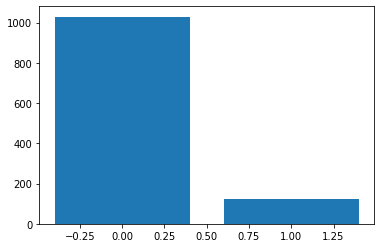

In [7]:
# Asthma groups distribution:
asthma_class = phenotype['hs_asthma']
asthma_counts = asthma_class.value_counts()
plt.bar(asthma_counts.index, asthma_counts)

asthma_class = asthma_class.values

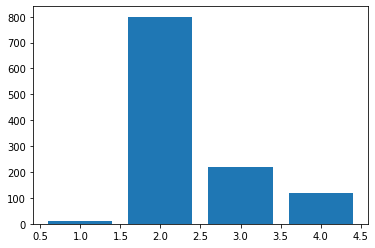

In [8]:
# BMI groups distribution:
bmi_class = phenotype['hs_bmi_c_cat']
bmi_counts = bmi_class.value_counts()
plt.bar(bmi_counts.index, bmi_counts)

bmi_class = bmi_class.values -1

# Raw data

## K-means


Try fitting K-means with a range of clusters. Compute the silhouette as a metric of QC. Plot the results.

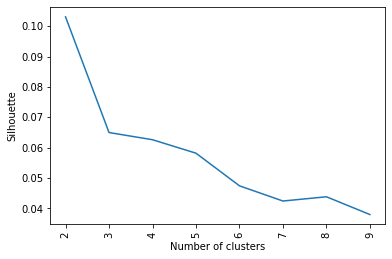

In [9]:
MIN_K = 2
MAX_K = 10

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=30)
    labels = kmeans.fit_predict(metabol_exprs)
    sils.append(sklearn.metrics.silhouette_score(metabol_exprs, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

The best result is achieved with K=2.

Since we know our categorical data has 2 and 4 classes, let's plot the 2D t-SNE representation for K=2 and K=4.

In [10]:
tsne = TSNE(n_components=2, init='pca')
raw_data_tsne = tsne.fit_transform(metabol_exprs)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.312']


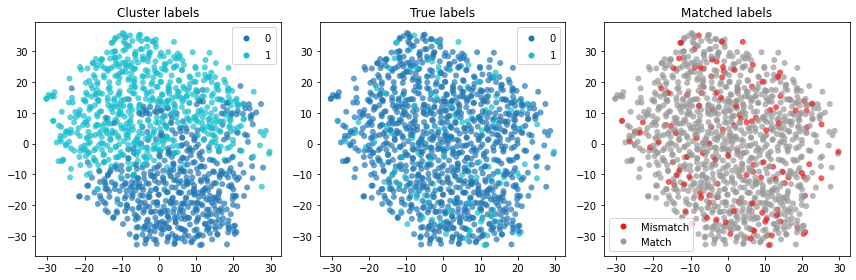

In [11]:
true_labels = asthma_class
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=30)
cluster_labels = kmeans.fit_predict(metabol_exprs)

metrics = evaluate_clustering(raw_data_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(raw_data_tsne, true_labels, cluster_labels, alpha=0.7)

['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.253']


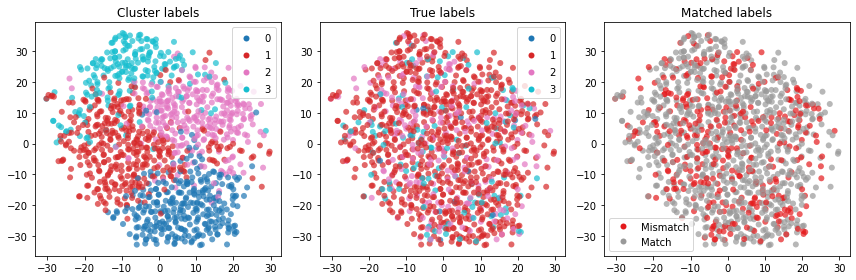

In [12]:
true_labels = bmi_class
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, n_init=30)
cluster_labels = kmeans.fit_predict(metabol_exprs)

metrics = evaluate_clustering(raw_data_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(raw_data_tsne, true_labels, cluster_labels, alpha=0.7)

## GMM

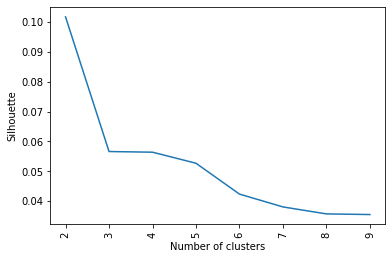

In [13]:
MIN_K = 2
MAX_K = 10

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=10)
    labels = gmm.fit_predict(metabol_exprs)
    sils.append(sklearn.metrics.silhouette_score(metabol_exprs, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.305']


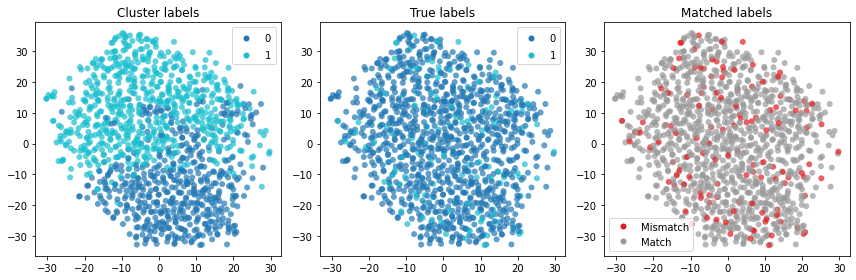

In [14]:
true_labels = asthma_class
n_clusters = 2

gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', n_init=10)
cluster_labels = gmm.fit_predict(metabol_exprs)

metrics = evaluate_clustering(raw_data_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(raw_data_tsne, true_labels, cluster_labels, alpha=0.7)

['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.212']


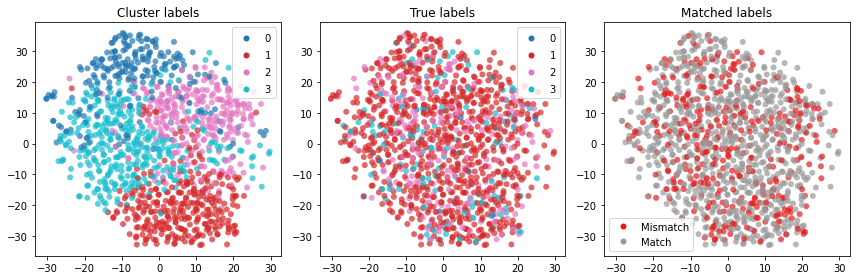

In [15]:
true_labels = bmi_class
n_clusters = 4

gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', n_init=10)
cluster_labels = gmm.fit_predict(metabol_exprs)

metrics = evaluate_clustering(raw_data_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(raw_data_tsne, true_labels, cluster_labels, alpha=0.7)

## Agglomerative

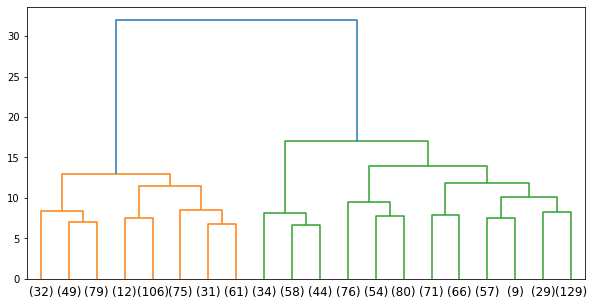

In [16]:
hier = hierarchy.linkage(metabol_exprs, method='ward', metric="euclidean")

plt.figure(figsize=(10, 5))
hierarchy.dendrogram(Z=hier, p=20, truncate_mode='lastp')
plt.show()

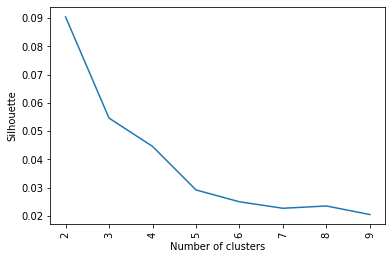

In [17]:
MIN_K = 2
MAX_K = 10

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    labels = hierarchy.cut_tree(hier, n_clusters=k).squeeze()
    sils.append(sklearn.metrics.silhouette_score(metabol_exprs, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.276']


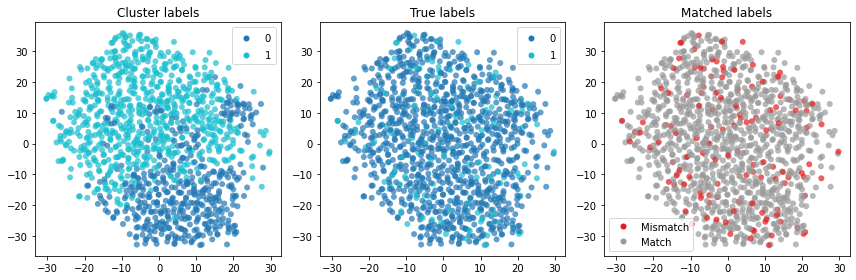

In [18]:
true_labels = asthma_class
n_clusters = 2

cluster_labels = hierarchy.cut_tree(hier, n_clusters=n_clusters).squeeze()
metrics = evaluate_clustering(raw_data_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(raw_data_tsne, true_labels, cluster_labels, alpha=0.7)

['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.102']


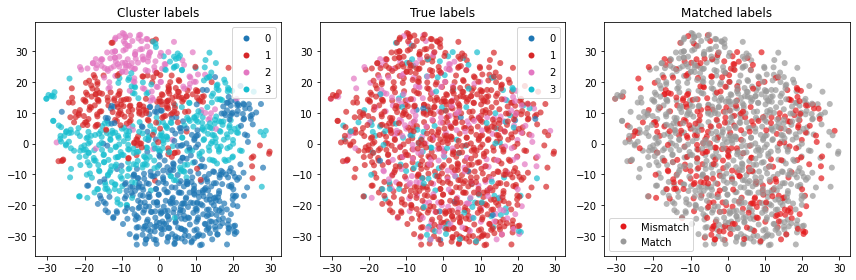

In [19]:
true_labels = bmi_class
n_clusters = 4

cluster_labels = hierarchy.cut_tree(hier, n_clusters=n_clusters).squeeze()
metrics = evaluate_clustering(raw_data_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(raw_data_tsne, true_labels, cluster_labels, alpha=0.7)

# PCA

In [40]:
# Find the number of PCs to explain 0.8 of the variance:
pca = PCA(n_components=0.8)
pca.fit(metabol_exprs)

z_pca = pca.transform(metabol_exprs)

# Number of PCs:
pca.n_components_

36

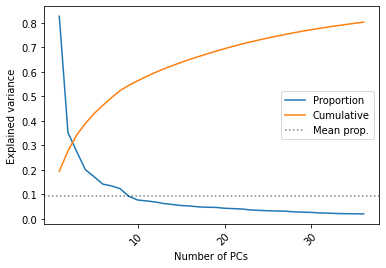

In [46]:
plt.plot(np.arange(0, pca.n_components_), pca.explained_variance_, label="Proportion")
plt.plot(np.arange(0, pca.n_components_), np.cumsum(pca.explained_variance_ratio_), label="Cumulative")
plt.axhline(y = np.mean(pca.explained_variance_), color='black', linestyle='dotted', alpha=0.5, label="Mean prop.")
plt.xticks(np.arange(9, pca.n_components_, 10), np.arange(10, pca.n_components_+1, 10), rotation=45, rotation_mode="anchor", ha='right')
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance');
plt.legend();

## K-means

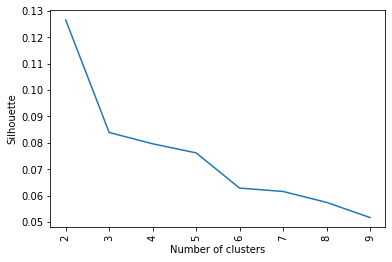

In [25]:
MIN_K = 2
MAX_K = 10

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=30)
    labels = kmeans.fit_predict(z_pca)
    sils.append(sklearn.metrics.silhouette_score(z_pca, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

In [26]:
tsne = TSNE(n_components=2, init='pca')
z_pca_tsne = tsne.fit_transform(z_pca)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.357']


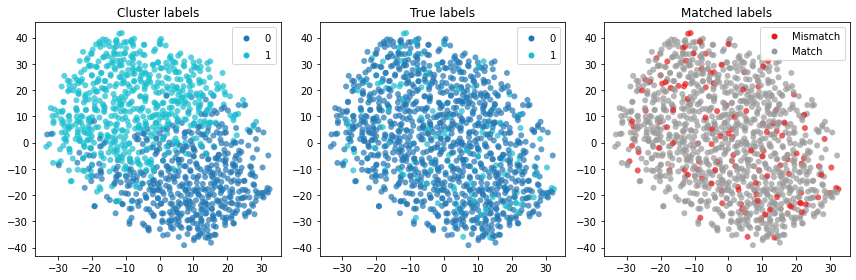

In [27]:
true_labels = asthma_class
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, n_init=30)
cluster_labels = kmeans.fit_predict(z_pca)

metrics = evaluate_clustering(z_pca_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(z_pca_tsne, true_labels, cluster_labels, alpha=0.7)

['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.224']


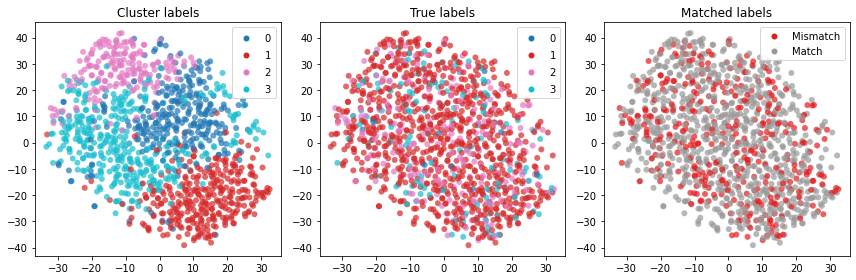

In [28]:
true_labels = bmi_class
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, n_init=30)
cluster_labels = kmeans.fit_predict(z_pca)

metrics = evaluate_clustering(z_pca_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(z_pca_tsne, true_labels, cluster_labels, alpha=0.7)

## GMM

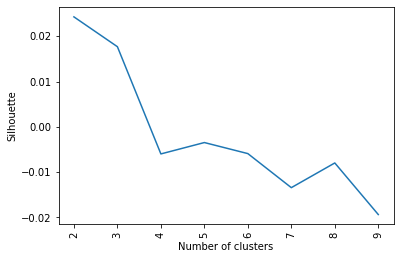

In [29]:
MIN_K = 2
MAX_K = 10

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', n_init=10)
    labels = gmm.fit_predict(z_pca)
    sils.append(sklearn.metrics.silhouette_score(z_pca, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.028']


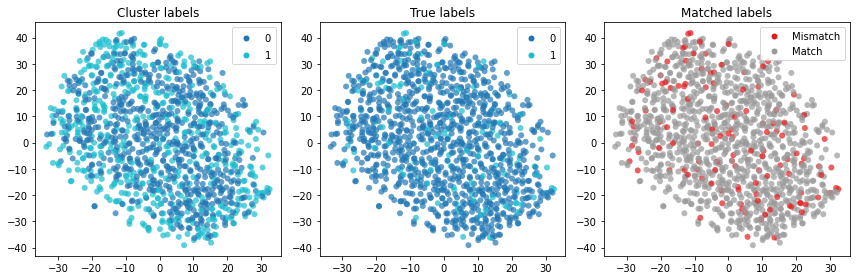

In [30]:
true_labels = asthma_class
n_clusters = 2

gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', n_init=10)
cluster_labels = gmm.fit_predict(z_pca)

metrics = evaluate_clustering(z_pca_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(z_pca_tsne, true_labels, cluster_labels, alpha=0.7)

['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: -0.026']


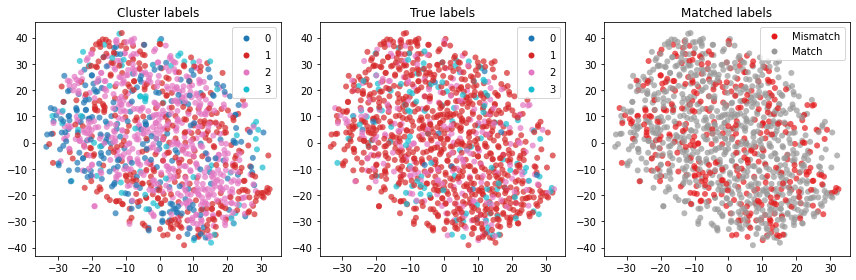

In [31]:
true_labels = bmi_class
n_clusters = 4

gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', n_init=10)
cluster_labels = gmm.fit_predict(z_pca)

metrics = evaluate_clustering(z_pca_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(z_pca_tsne, true_labels, cluster_labels, alpha=0.7)

## Agglomerative

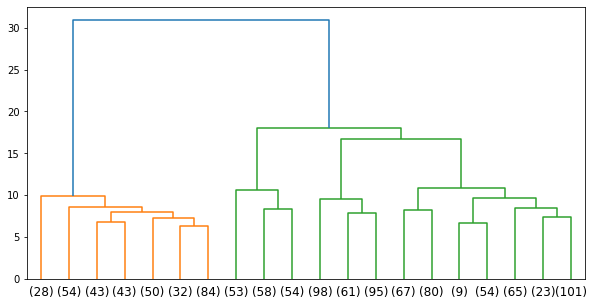

In [32]:
pca_hier = hierarchy.linkage(z_pca, method='ward', metric="euclidean")

plt.figure(figsize=(10, 5))
hierarchy.dendrogram(Z=pca_hier, p=20, truncate_mode='lastp')
plt.show()

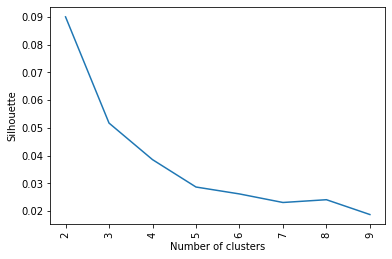

In [33]:
MIN_K = 2
MAX_K = 10

ks = np.arange(MIN_K, MAX_K)
sils = []
for k in ks:
    labels = hierarchy.cut_tree(pca_hier, n_clusters=k).squeeze()
    sils.append(sklearn.metrics.silhouette_score(metabol_exprs, labels))

plt.plot(sils)
plt.xticks(np.arange(0, len(ks)), ks, rotation=90)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette');

['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.339']


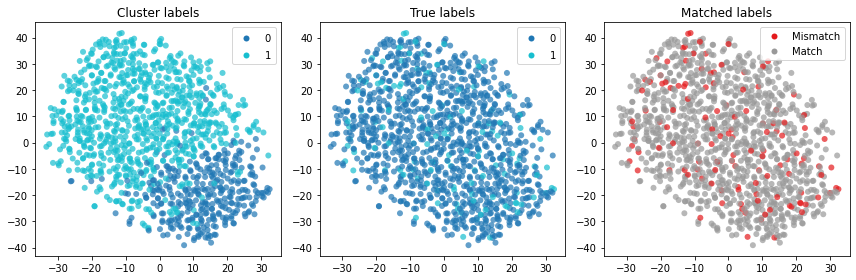

In [34]:
true_labels = asthma_class
n_clusters = 2

cluster_labels = hierarchy.cut_tree(pca_hier, n_clusters=n_clusters).squeeze()
metrics = evaluate_clustering(z_pca_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(z_pca_tsne, true_labels, cluster_labels, alpha=0.7)

['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.178']


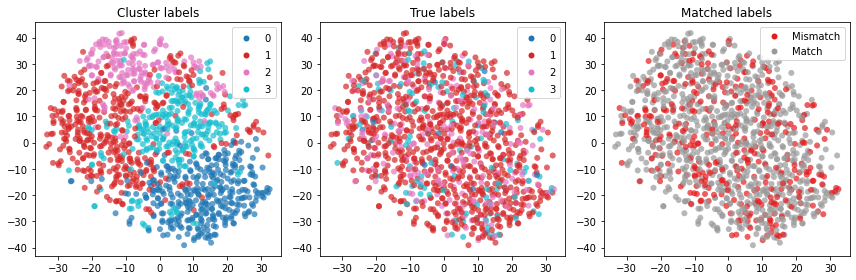

In [35]:
true_labels = bmi_class
n_clusters = 4

cluster_labels = hierarchy.cut_tree(pca_hier, n_clusters=n_clusters).squeeze()
metrics = evaluate_clustering(z_pca_tsne, true_labels, cluster_labels, False)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])
draw_matched_labels(z_pca_tsne, true_labels, cluster_labels, alpha=0.7)